<center><h1>Last_First_HW4</h1></center>
<br>
<br>

Name: 
<br>
Github Username: 
<br>
USC ID: 

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [15]:
import os
import pandas as pd
import numpy as np
import random 
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns
import matplotlib.pyplot as plt


Get the AReM Data Set

In [16]:
directory = "../AReM/"


def custom_tt_split(directory, directory_name, count):
    ret_list1, ret_list2 = [], []
    c = 0
    for filename in os.listdir(directory + directory_name):
        if "csv" in filename:
            if c < count:
                ret_list1.append(pd.read_csv(directory + directory_name + filename, comment="#", header=None))
            else:
                ret_list2.append(pd.read_csv(directory + directory_name + filename, comment="#", header=None))
            c += 1
    return [ret_list1, ret_list2]

[bending_test, bending_train] = custom_tt_split(directory, "bending1/", 2)
[bending_test2, bending_train2] = custom_tt_split(directory, "bending2/", 2)
[bending_test, bending_train] = [bending_test + bending_test2, bending_train + bending_train2]
[cycling_test, cycling_train] = custom_tt_split(directory, "cycling/", 3)
[lying_test, lying_train] = custom_tt_split(directory, "lying/", 3)
[sitting_test, sitting_train] = custom_tt_split(directory, "sitting/", 3)
[standing_test, standing_train] = custom_tt_split(directory, "standing/", 3)
[walking_test, walking_train] = custom_tt_split(directory, "walking/", 3)


### (b) Splitting Data

In [17]:
test_data = [bending_test, cycling_test, lying_test, sitting_test, standing_test, walking_test]
train_data = [bending_train, cycling_train, lying_train, sitting_train, standing_train, walking_train]

### (c) Feature Extraction

In [18]:
def metrics_extraction(t_data, columns, sortedIndex):
    metrics_df = pd.DataFrame({}, columns = columns)
    bending = "bending"
    for data in t_data:
        for df in data:
            instance_metrics = []
            for i in range(1, 7): 
                metrics = list(df[i].describe())
                metrics = [metrics[m] for m in range(0, len(metrics)) if m not in [0, 5]]
                metrics.insert(3, df[i].median())
                
                # goal: min, max, mean, median, std, 25, 75
                #      mean, std, min, median, 25, 75, max
                metrics = [metrics[i] for i in sortedIndex]
                
                instance_metrics = instance_metrics + metrics
            instance_metrics.append(bending)
            metrics_df.loc[len(metrics_df)] = instance_metrics
        if bending == "bending":
            bending = "non-bending"
    return metrics_df


metric_names, metric_offset = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"], 1
column_names = ["min", "max", "mean", "median", "std", "first_quartile", "third_quartile"]
sortedIndex = [2, 6, 0, 3, 1, 4, 5]
column_names_expanded = [f"{c}{i}" for i in range(metric_offset, len(metric_names) + metric_offset) for c in column_names ]
column_names_expanded.append("class")

train_metrics_df = metrics_extraction(train_data, column_names_expanded, sortedIndex)
test_metrics_df = metrics_extraction(test_data, column_names_expanded, sortedIndex)
    
train_confidence_intervals = {}
test_confidence_intervals = {}


for feature in train_metrics_df:
    if feature != "class":
        train_confidence_intervals[feature] = bs.bootstrap(train_metrics_df[feature].to_numpy(), stat_func=bs_stats.std, alpha=0.1)
    
for feature in test_metrics_df:
    if feature != "class":
        test_confidence_intervals[feature] = bs.bootstrap(test_metrics_df[feature].to_numpy(), stat_func=bs_stats.std, alpha=0.1)
    
train_extracted_df = train_metrics_df[["std1", 
                        "first_quartile1", 
                        "third_quartile1",
                        "std2", 
                        "first_quartile2", 
                        "third_quartile2",
                        "std3", 
                        "first_quartile3", 
                        "third_quartile3",
                        "std4", 
                        "first_quartile4", 
                        "third_quartile4",
                        "std5", 
                        "first_quartile5", 
                        "third_quartile5",
                        "std6", 
                        "first_quartile6", 
                        "third_quartile6",
                        "class"]]

test_extracted_df = train_metrics_df[["std1", 
                        "first_quartile1", 
                        "third_quartile1",
                        "std2", 
                        "first_quartile2", 
                        "third_quartile2",
                        "std3", 
                        "first_quartile3", 
                        "third_quartile3",
                        "std4", 
                        "first_quartile4", 
                        "third_quartile4",
                        "std5", 
                        "first_quartile5", 
                        "third_quartile5",
                        "std6", 
                        "first_quartile6", 
                        "third_quartile6",
                        "class"]]

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

(69, 10)


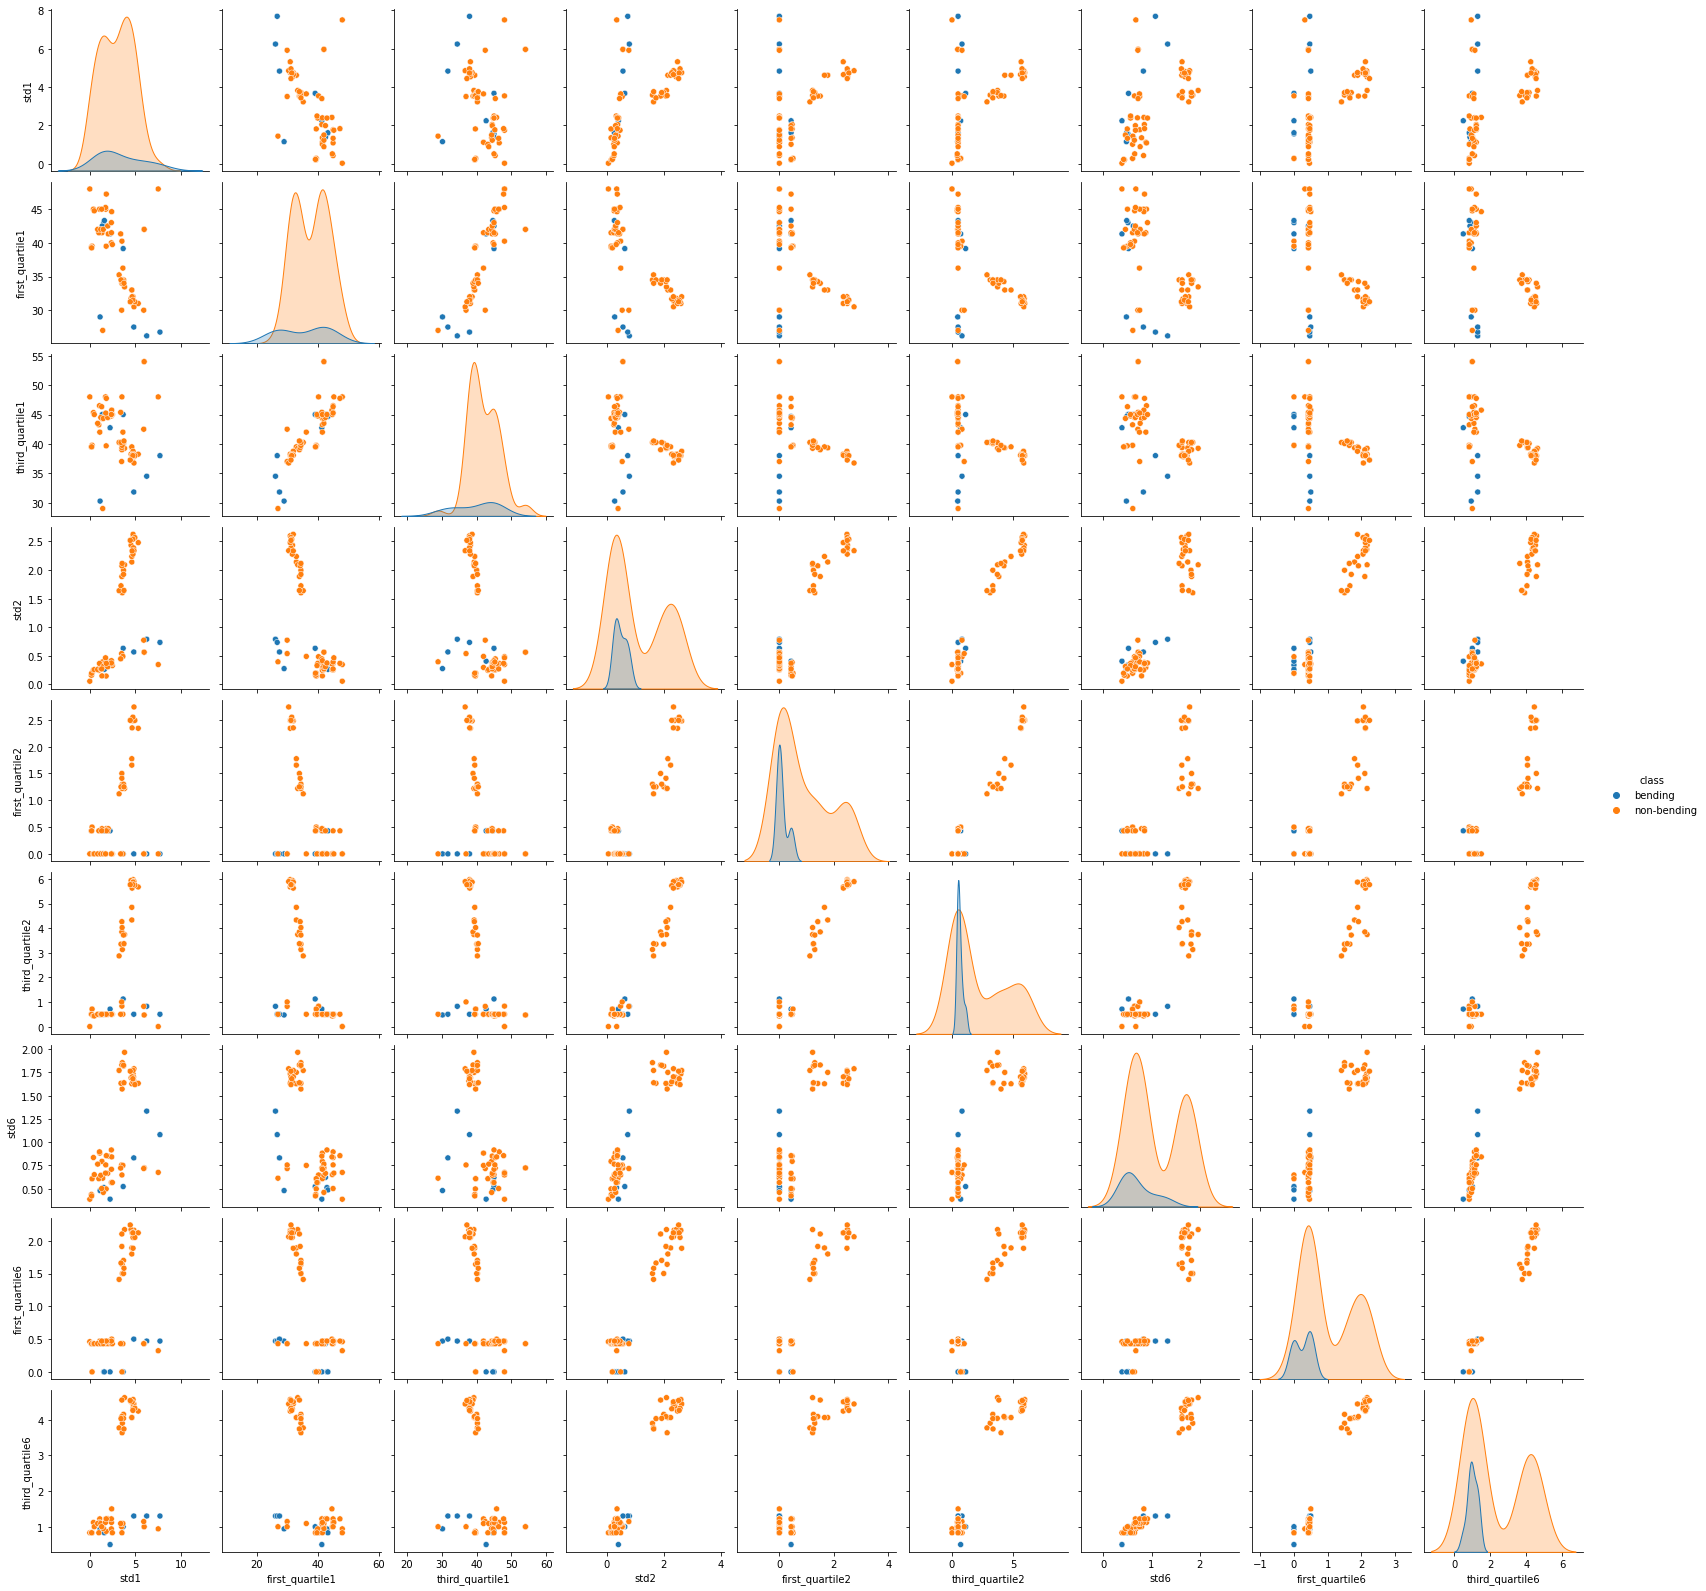

In [26]:
# take selected features from time series 1, 2, 6

train_filtered_df = train_extracted_df[["std1", 
                        "first_quartile1", 
                        "third_quartile1",
                        "std2", 
                        "first_quartile2", 
                        "third_quartile2",
                        "std6", 
                        "first_quartile6", 
                        "third_quartile6",
                        "class"]]

print(train_filtered_df.shape)

sns.pairplot(train_filtered_df, hue="class")

#### ii. Splitted Plots

        0      1      2      3      4      5      6      7      8      9  ...  \
1   42.00  41.50  41.50  40.75  40.00  41.25  42.25  43.50  42.75  43.25  ...   
2    0.71   0.50   0.50   0.83   0.71   0.83   0.43   0.87   0.83   0.43  ...   
3   21.25  20.25  14.25  15.75  20.00  24.25  23.75  21.00  21.25  23.75  ...   
4    0.43   1.48   1.92   0.43   2.74   0.43   0.43   0.00   0.43   0.43  ...   
5   30.00  31.25  33.00  33.00  32.75  31.50  35.25  36.00  36.00  36.00  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
2    1.50   6.30   3.34   8.92   5.55   3.74   2.62   5.61   5.12   8.32  ...   
3   20.75  16.50  19.00  16.33  19.75  17.67  13.33  18.25  16.33  20.80  ...   
4    0.43   3.35   0.71   5.25   3.49   2.87   1.89   2.77   1.89   1.72  ...   
5   11.00  14.33  14.75  15.33  21.75  18.67  14.50  18.00  16.67  16.00  ...   
6    2.35   4.78   1.09   5.79   1.30   7.54   8.65   4.24   4.64   1.90  ...   

      233    234    235    

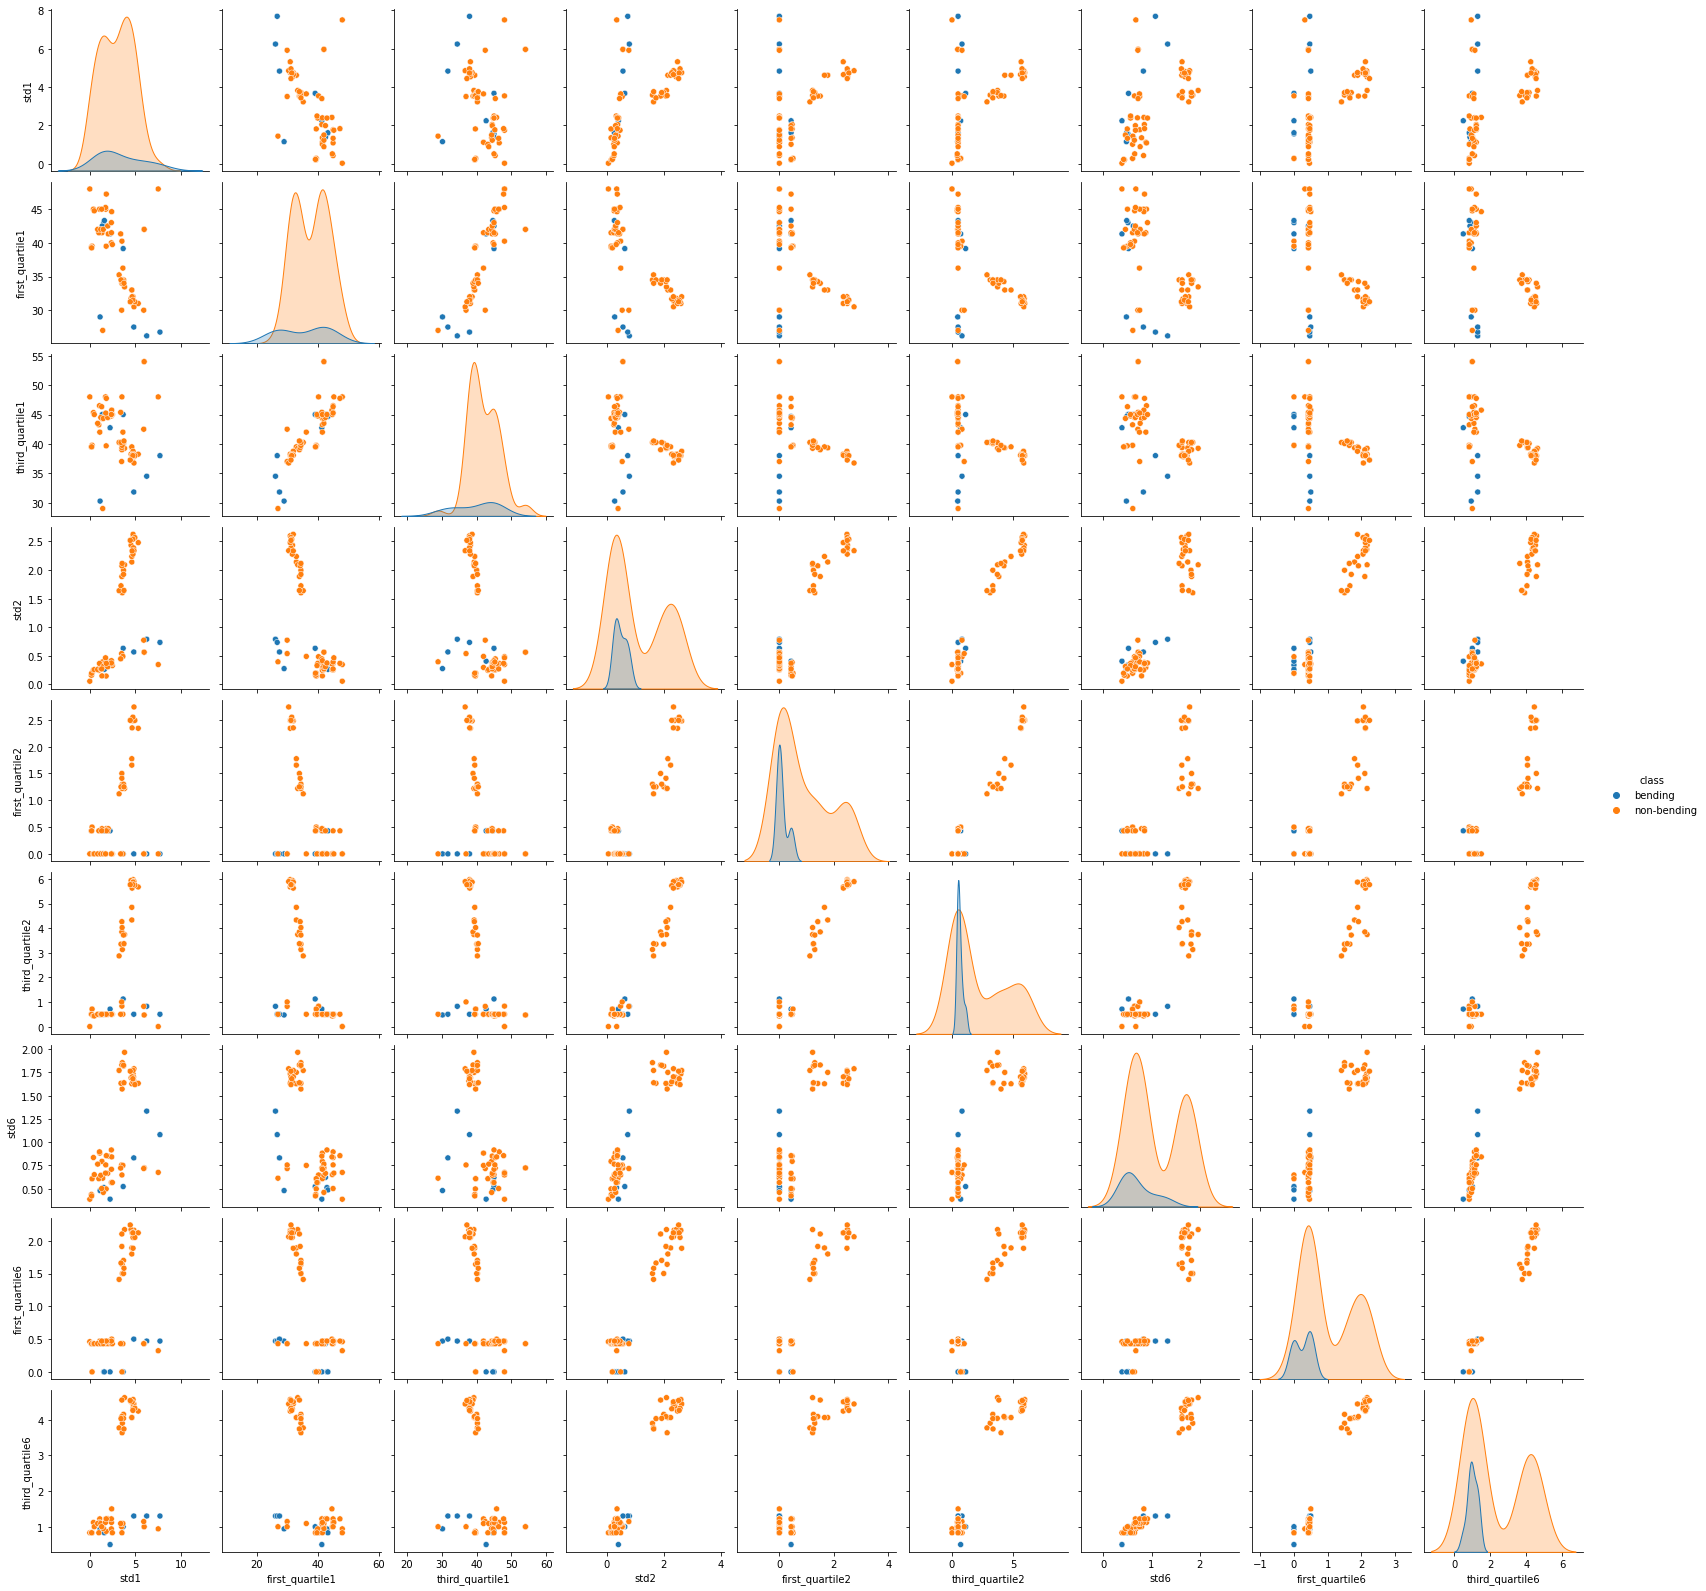

In [32]:
test_data = {"bending":bending_test, "cycling":cycling_test, "lying":lying_test, "sitting":sitting_test, "standing":standing_test, "walking":walking_test}
train_data = {"bending":bending_train, "cycling":cycling_train, "lying":lying_train, "sitting":sitting_train, "standing":standing_train, "walking":walking_train}

train_data_r=pd.DataFrame({})
test_data_r=pd.DataFrame({})

def reformat(dct, output_df):
    class_list, exertype_list, instance_list = [], [], []
    instance = 0
    for exertype in dct.keys():
        for series in dct[exertype]:
            class_list += [str(x) for x in range(1, 13)]
            exertype_list += [exertype for x in range(1, 13)]
            instance_list += [instance for x in range(1, 13)]
            instance += 1
            df = pd.DataFrame(series)
            df1 = df.iloc[:240,:].drop(columns=[0]).T
            df2 = df.iloc[240:,:].drop(columns=[0]).T
            df2.columns = [x for x in range(len(df2.columns))]
            output_df = pd.concat([output_df, df1], axis=0)
            output_df = pd.concat([output_df, df2], axis=0)
    return output_df, class_list, exertype_list, instance_list

def metric_calc(input_df):
    calc_df = input_df.drop(columns=["class", "exercise", "instance"])
    metric_df = pd.DataFrame({})
    metric_df['mean'] = calc_df.mean(axis=1)
    metric_df['median'] = calc_df.median(axis=1)
    metric_df['max'] = calc_df.max(axis=1)
    metric_df['min'] = calc_df.min(axis=1)
    metric_df['1quart'] = calc_df.quantile(0.25)
    metric_df['3quart'] = calc_df.quantile(0.75)
    metric_df['class'] = input_df['class']
    metric_df['exercise'] = input_df['exercise']
    metric_df['instance'] = input_df['instance']
    #expand these metrics by 6
    return metric_df
    
    

[train_data_r, train_class_list, train_exertype_list, train_instances] = reformat(train_data, train_data_r)
[test_data_r, test_class_list, test_exertype_list, test_instances] = reformat(test_data, test_data_r)

train_data_r["class"] = train_class_list
test_data_r["class"] = test_class_list
train_data_r["exercise"] = train_exertype_list
test_data_r["exercise"] = test_exertype_list
train_data_r["instance"] = train_instances
test_data_r["instance"] = test_instances

train_metric_r = metric_calc(train_data_r)
test_metric_r = metric_calc(test_data_r)

print(train_data_r)

sns.pairplot(train_filtered_df, hue="class")


#### iii. Time Series Segments

#### iv. Confusion Matrix

#### v. Test Classifier

#### vi. Separation

#### vii. Imbalance

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

#### ii. Comparison

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

#### ii. Naive Bayes

#### ii. Comparison

## 3. ISLR 4.8.3

## 4. ISLR 4.8.7

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9